In [2]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pickle as pk
import json
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""
display(HTML('<style>{}</style>'.format(CSS)))
from IPython.display import display, HTML

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell reads the Waypoint.csv file 10 million rows (as a chunk of data) at a time and writes each chunk into a new file </p></font><br>
<font size="3">
<b>Input</b> &rarr; Waypoints.csv - (~53 Million Rows) <br>
<b>Output</b> &rarr; 53 (.csv) files each with 10 Million rows. </font>
</div>
 

In [42]:
i=1
for chunk in pd.read_csv("Inputs/Waypoints.csv",chunksize=10000000):
    chunk.to_csv(f"Outputs/Chunks/Chunk{i}.csv",index=False)
    i+=1

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell drops duplicate waypoints in each chunk file generated in the previous cell and concatenates all the unique waypoints into one dataframe (AllChunks) </p><br></font> 
<font size="3">
<b>Input</b> &rarr; 53 (.csv) files each with 10 Million rows (containing duplicates) <br>
<b>Output</b> &rarr; AllChunks Dataframe</font> 
</div>

In [17]:
ChunkArray=[]
i=1
while(i<=53):
    chunk=pd.read_csv(f"Chunks/Chunk{i}.csv")
    df=chunk.iloc[:,3:6]
    chunk_no_duplicates=df.drop_duplicates(keep='first')
    chunk_no_duplicates=chunk_no_duplicates.reset_index()
    chunk_no_duplicates.drop(['index'],axis=1,inplace=True)
    ChunkArray.append(chunk_no_duplicates)
    print(f"Chunk{i} Done")
    i+=1
AllChunks=pd.concat(ChunkArray)
AllChunks=AllChunks.reset_index()
AllChunks.drop(['index'],axis=1,inplace=True)

Chunk1 Done
Chunk2 Done
Chunk3 Done
Chunk4 Done
Chunk5 Done
Chunk6 Done
Chunk7 Done
Chunk8 Done
Chunk9 Done
Chunk10 Done
Chunk11 Done
Chunk12 Done
Chunk13 Done
Chunk14 Done
Chunk15 Done
Chunk16 Done
Chunk17 Done
Chunk18 Done
Chunk19 Done
Chunk20 Done
Chunk21 Done
Chunk22 Done
Chunk23 Done
Chunk24 Done
Chunk25 Done
Chunk26 Done
Chunk27 Done
Chunk28 Done
Chunk29 Done
Chunk30 Done
Chunk31 Done
Chunk32 Done
Chunk33 Done
Chunk34 Done
Chunk35 Done
Chunk36 Done
Chunk37 Done
Chunk38 Done
Chunk39 Done
Chunk40 Done
Chunk41 Done
Chunk42 Done
Chunk43 Done
Chunk44 Done
Chunk45 Done
Chunk46 Done
Chunk47 Done
Chunk48 Done
Chunk49 Done
Chunk50 Done
Chunk51 Done
Chunk52 Done
Chunk53 Done


<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell drops duplicate waypoints in the dataframe generated from the previous cell and converts it into a csv file </p><br></font> 
<font size="3">
<b>Input</b> &rarr;  AllChunks Dataframe <br>
<b>Output</b> &rarr; WAYPOINT_FILE.csv</font> 
</div>

In [43]:
dfWayPoints=AllChunks.drop_duplicates(keep='first')
dfWayPoints=dfWayPoints.reset_index()
dfWayPoints.drop(['index'],axis=1,inplace=True)

dfWayPoints.to_csv("Outputs/WAYPOINT_FILE.csv",index=False)
dfWP_F=pd.read_csv("Outputs/WAYPOINT_FILE.csv")
dfWP_F

,latitude,longitude
0,39.866667,-75.233333
1,39.866667,-75.150000
2,39.783333,-75.116667
3,39.783333,-75.066667
4,39.783333,-75.050000
...,...,...
3817923,45.250000,93.700000
3817924,45.300000,93.800000
3817925,45.516667,94.233333
3817926,45.816667,94.866667


<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell uses the Basemap library to convert the spherical coordinates into cartesian and plot it on a map projection to give a visual representation of the waypoint locations  </p><br></font> 
<font size="3">
<b>Input</b> &rarr;  WAYPOINT_FILE.csv <br>
<b>Output</b> &rarr; Visual Representation of the Waypoints plotted on a Map Projection</font> 
</div>

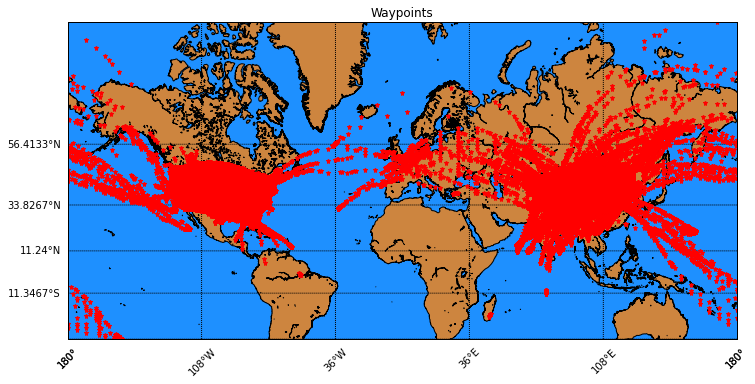

In [56]:
lats, lons = [],[]
with open('Outputs/WAYPOINT_FILE.csv') as csvfile:
    reader = csv.DictReader(csvfile,delimiter=',')
    for data in reader:
        lats.append(float(data['latitude']))
        lons.append(float(data['longitude']))

# How much to zoom from coordinates (in degrees)
zoom_scale = 0

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='peru',lake_color='dodgerblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary(fill_color='dodgerblue')

# build and plot coordinates onto map
x,y = m(lons,lats)
m.plot(x,y,'r*',markersize=5)
plt.title("Waypoints")
plt.savefig('Full_Waypoint_Figure.png', format='png', dpi=500)
plt.show()

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell filters the waypoints generated such that only those covering the USA region are considered   </p><br></font> 
<font size="3">
<b>Input</b> &rarr;  WAYPOINT_FILE.csv <br>
<b>Output</b> &rarr; WAYPOINT_FILE_US.csv </font> 
</div>

In [4]:
df=pd.read_csv("Outputs/WAYPOINT_FILE.csv")


dfUS=df[(df.latitude >= 24) & (df.latitude <= 50) & (df.longitude >= -126) & (df.longitude <= -66)]
dfUS=dfUS.reset_index()
dfUS.drop(['index'],axis=1,inplace=True)

dfUS.to_csv("Outputs/WAYPOINT_FILE_US.csv",index=False)
dfWP_F_US=pd.read_csv("Outputs/WAYPOINT_FILE_US.csv")
display(dfWP_F_US)

,latitude,longitude
0,39.866667,-75.233333
1,39.866667,-75.150000
2,39.783333,-75.116667
3,39.783333,-75.066667
4,39.783333,-75.050000
...,...,...
2313979,43.066667,-117.833333
2313980,42.016667,-117.833333
2313981,28.566667,-125.983333
2313982,28.066667,-125.316667


<div>
<font size="4",style="font-family:Ubuntu"> <p>  We use the Basemap library to get a metric (M) that will help us convert the spherical coordinates of the USA waypoints into cartesian which we store in a pickle file for future use.</p><p>We also generate a new CSV file containing the cartesian coordinates of each USA Waypoint called EastFile.csv</p> <br></font> 
<font size="3">
<b>Input</b> &rarr;  WAYPOINT_FILE_US.csv <br>
<b>Output</b> &rarr; M_ConversionMetric.pkl, East_File.csv </font> 
</div>

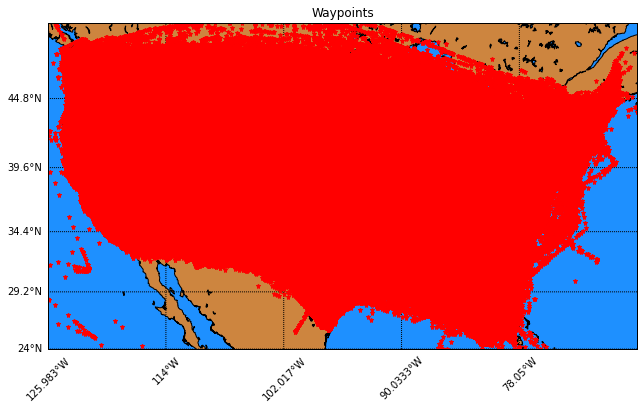

,easting,northing
0,5.557408e+06,2.059070e+06
1,5.566533e+06,2.059070e+06
2,5.570184e+06,2.047188e+06
3,5.575659e+06,2.047188e+06
4,5.577484e+06,2.047188e+06
...,...,...
2313979,8.924704e+05,2.526860e+06
2313980,8.924704e+05,2.370797e+06
2313981,0.000000e+00,5.579567e+05
2313982,7.300372e+04,4.957613e+05


In [5]:
lats, lons = [],[]
with open('Outputs/WAYPOINT_FILE_US.csv') as csvfile:
    reader = csv.DictReader(csvfile,delimiter=',')
    for data in reader:
        lats.append(float(data['latitude']))
        lons.append(float(data['longitude']))

# How much to zoom from coordinates (in degrees)
zoom_scale = 0

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

m_dump=open("Outputs/M_ConversionMetric.pkl","wb")
pk.dump(m,m_dump)
m_dump.close()

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='peru',lake_color='dodgerblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary(fill_color='dodgerblue')

# build and plot coordinates onto map
x,y = m(lons,lats)
m.plot(x,y,'r*',markersize=5)
plt.title("Waypoints")
plt.savefig('figure.png', format='png', dpi=500)
plt.show()
dfE=pd.DataFrame()
dfE['easting']=x
dfE['northing']=y


dfE.to_csv("Outputs/East_File.csv",index=False)
dfE_F=pd.read_csv("Outputs/East_File.csv")
dfE_F

<div>
<font size="4",style="font-family:Ubuntu"> <p> We use the M Conversion metric to obtain the cartesian coordinates of a set of 63 airports (whose spherical coordinates we procure from a JSON file). A csv file is generated containing these cartesian coordinates as well as other information such as radius and elevation </p> <br></font> 
<font size="3">
<b>Input</b> &rarr;  M_ConversionMetric.pkl, Airports.csv, airports.json, East_File.csv  <br>
<b>Output</b> &rarr; AirportsFinal.csv </font> 
</div>

,airport,easting,northing,elevation,radius,height
0,KABQ,2.121597e+06,1.392865e+06,5355.0,65.1732,18000
1,KATL,4.550530e+06,1.206726e+06,1026.0,65.1732,18000
2,KBNA,4.304131e+06,1.538867e+06,599.0,65.1732,18000
3,KBOS,6.020412e+06,2.422176e+06,20.0,65.1732,18000
4,KBUR,8.349069e+05,1.281153e+06,778.0,65.1732,18000
...,...,...,...,...,...,...
58,KSTL,3.899858e+06,1.900844e+06,618.0,65.1732,18000
59,KTPA,4.758031e+06,4.844524e+05,26.0,65.1732,18000
60,KTUL,3.295596e+06,1.548890e+06,677.5,65.1732,18000
61,KTUS,1.647219e+06,1.008448e+06,2643.2,65.1732,18000


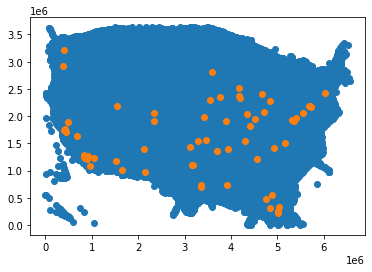

In [4]:
m = pk.load(open("Outputs/M_ConversionMetric.pkl", "rb"))
dfAirports=pd.read_csv("Inputs/Airports.csv")
f = open('Inputs/airports.json')
df_East_file=pd.read_csv("Outputs/East_File.csv")

data = json.load(f)
dfAirportsFinal=pd.DataFrame()
airportList=list(dfAirports["airport"])
latitudes=[]
longitudes=[]
for airport in airportList:
    lat=data[airport]['lat']
    lon=data[airport]['lon']
    latitudes.append(lat)
    longitudes.append(lon)
xAir,yAir=m(longitudes,latitudes)
x1=df_East_file["easting"]
y1=df_East_file["northing"]
plt.scatter(x1,y1)
plt.scatter(xAir,yAir)
dfAirportsFinal["airport"]=airportList
dfAirportsFinal["easting"]=xAir
dfAirportsFinal["northing"]=yAir
dfAirportsFinal["elevation"]=dfAirports["elevation"]
dfAirportsFinal["radius"]=dfAirports["radius"]
dfAirportsFinal["height"]=dfAirports["height"]


dfAirportsFinal.to_csv("Outputs/AirportsFinal.csv",index=False)
dfAirFinal=pd.read_csv("Outputs/AirportsFinal.csv")
dfAirFinal